# What-if Analysis

This notebook describes how to create forecasts and perform what-if analysis from different versions of related time series datasets. As a sample use-case, we use product demand forecasting with two different variations of future prices, and see how product demand changes if we increase the prices of products.

Please note that We can use just one Predictor to generate two Forecasts. Following is the steps:

1. [Import libraries and setup AWS resources](#import_and_setup)
2. [Prepare training dataset CSVs](#prepare_csvs)
3. [Create DatasetGroup and Datasets](#create_dsg_ds)
4. [Import the target time series data, and the first variation of the related time series](#import_1)
5. [Create Predictor](#create_predictor)
6. [Create Forecast from the first variation of the related time series](#forecast_1)
7. [Import 2nd variation of the related time series](#import_2)
8. [Create Forecast from the 2nd variation of the related time series](#forecast_2)
9. [Query forecasts, visualize and compare](#visualize_and_compare)
10. [Resource Cleanup](#cleanup)

## Import libraries and setup AWS resources <a class="anchor" id="import_and_setup">

In [1]:
import sys
import os
import time
import datetime

import pandas as pd
import matplotlib.pyplot as plt

import boto3

# importing forecast notebook utility from notebooks/common directory
sys.path.insert( 0, os.path.abspath("../../common") )
import util

Configure the S3 bucket name and region name for this lesson.

- If you don't have an S3 bucket, create it first on S3.
- Although we have set the region to us-east-1 as a default value below, you can choose any of the regions that the service is available in.

In [3]:
text_widget_bucket = util.create_text_widget( "bucket_name", "input your S3 bucket name", default_value="316031960777-forecast-what-if-demo" )
text_widget_region = util.create_text_widget( "region", "input region name.", default_value="us-east-1" )

Text(value='316031960777-forecast-what-if-demo', description='bucket_name', placeholder='input your S3 bucket …

Text(value='us-east-1', description='region', placeholder='input region name.')

In [4]:
bucket_name = text_widget_bucket.value
assert bucket_name, "bucket_name not set."

region = text_widget_region.value
assert region, "region not set."

In [5]:
session = boto3.Session(region_name=region)
s3 = session.client('s3')
forecast = session.client(service_name='forecast') 
forecastquery = session.client(service_name='forecastquery')

In [6]:
# Create the role to provide to Amazon Forecast.
role_name = "ForecastNotebookRole-WhatIfAnalysis"
role_arn = util.get_or_create_iam_role( role_name = role_name )

Created arn:aws:iam::316031960777:role/ForecastNotebookRole-WhatIfAnalysis
Attaching policies
Waiting for a minute to allow IAM role policy attachment to propagate
Done.


## Prepare training dataset CSVs <a class="anchor" id="prepare_csvs">
1. Load historical product demand data
2. Split into target time series (demand) and related time series (price)
3. Extend related time series to forecast horizon
4. Create another variation of related time series data with increased price in forecast horizon
5. Upload them onto S3

In [7]:
df = pd.read_csv( "./data/product_demand.csv" )
df

,item_id,timestamp,demand,price
0,item_001,2017-10-01,305.824943,103.000000
1,item_002,2017-10-01,273.842872,102.000000
2,item_003,2017-10-01,322.919284,100.158361
3,item_004,2017-10-01,272.553474,93.000000
4,item_005,2017-10-01,271.672173,109.000000
5,item_006,2017-10-01,259.800720,103.000000
6,item_007,2017-10-01,343.645647,93.000000
7,item_008,2017-10-01,293.096242,104.000000
8,item_009,2017-10-01,203.698047,93.641077
9,item_010,2017-10-01,293.753571,101.000000


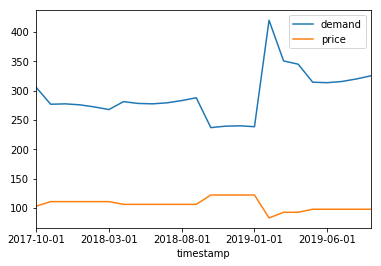

In [8]:
df[ df["item_id"]=="item_001" ].plot( x="timestamp" )

In [9]:
df_tts = df[["item_id", "timestamp", "demand" ]]
df_rts = df[["item_id", "timestamp", "price" ]]

For the first variation of related time series, we simply extend the latest price of each product toward forecast horizon to see what if we don't change the price.

In [10]:
# extend RTS to forecast horizon
training_data_period = ( df_tts["timestamp"].min(), df_tts["timestamp"].max() )

df_rts_extend = df_rts[ df_rts["timestamp"]==training_data_period[1] ].copy()

date = pd.to_datetime(training_data_period[1])
for i in range(3):

    if date.month == 12:
        date = datetime.date( date.year+1, 1, 1 )
    else:
        date = datetime.date( date.year, date.month+1, 1 )

    df_rts_extend[ "timestamp" ] = date.strftime("%Y-%m-%d")
    df_rts = df_rts.append(df_rts_extend)

df_rts[ df_rts["item_id"]=="item_001" ]

,item_id,timestamp,price
0,item_001,2017-10-01,103.000000
300,item_001,2017-11-01,110.795480
600,item_001,2017-12-01,110.795480
900,item_001,2018-01-01,110.795480
1200,item_001,2018-02-01,110.795480
1500,item_001,2018-03-01,110.795480
1800,item_001,2018-04-01,106.110140
2100,item_001,2018-05-01,106.110140
2400,item_001,2018-06-01,106.110140
2700,item_001,2018-07-01,106.110140


For the 2nd variation of related time series, we apply 10% price increase for the firt 10 items ("item_001" ~ "item_010"). Using this related time series, we will to see what if we increase the price.

In [11]:
# create different version of RTS with increased future price
df_rts1 = df_rts
df_rts2 = df_rts.copy()

df_rts2.loc[ ( df_rts2["timestamp"]>training_data_period[1] ) & (df_rts2["item_id"]<="item_010"), "price" ] *= 1.1

df_rts2[ df_rts2["item_id"]=="item_001" ]

,item_id,timestamp,price
0,item_001,2017-10-01,103.000000
300,item_001,2017-11-01,110.795480
600,item_001,2017-12-01,110.795480
900,item_001,2018-01-01,110.795480
1200,item_001,2018-02-01,110.795480
1500,item_001,2018-03-01,110.795480
1800,item_001,2018-04-01,106.110140
2100,item_001,2018-05-01,106.110140
2400,item_001,2018-06-01,106.110140
2700,item_001,2018-07-01,106.110140


In [12]:
df_tts.to_csv( "./data/tts.csv", index=False )
df_rts1.to_csv( "./data/rts1.csv", index=False )
df_rts2.to_csv( "./data/rts2.csv", index=False )

#### Upload to S3

In [13]:
project = "whatif_analysis"

key_tts = "%s/tts.csv" % project
key_rts1 = "%s/rts1.csv" % project
key_rts2 = "%s/rts2.csv" % project

s3.upload_file( Filename="./data/tts.csv", Bucket=bucket_name, Key=key_tts )
s3.upload_file( Filename="./data/rts1.csv", Bucket=bucket_name, Key=key_rts1 )
s3.upload_file( Filename="./data/rts2.csv", Bucket=bucket_name, Key=key_rts2 )

s3_data_path_tts = "s3://" + bucket_name + "/" + key_tts
s3_data_path_rts1 = "s3://" + bucket_name + "/" + key_rts1
s3_data_path_rts2 = "s3://" + bucket_name + "/" + key_rts2

# Create DatasetGroup and Datasets <a class="anchor" id="create_dsg_ds">
    
Creating single set of DatasetGroup, Datasets. Please note that we don't have to create two RELATED_TIME_SERIES datasets.

In [14]:
response = forecast.create_dataset_group(
    DatasetGroupName = project + "what_if_dsg_001",
    Domain="RETAIL",
    )

dataset_group_arn = response['DatasetGroupArn']

In [15]:
DATASET_FREQUENCY = "M"
TIMESTAMP_FORMAT = "yyyy-MM-dd"

schema ={
   "Attributes":[
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      },
      {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"demand",
         "AttributeType":"float"
      },
   ]
}

response = forecast.create_dataset(
    Domain = "RETAIL",
    DatasetType = 'TARGET_TIME_SERIES',
    DatasetName = project + "_tts",
    DataFrequency = DATASET_FREQUENCY, 
    Schema = schema
)

tts_dataset_arn = response['DatasetArn']

In [16]:
schema ={
   "Attributes":[
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      },
      {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"price",
         "AttributeType":"float"
      },
   ]
}

response = forecast.create_dataset(
    Domain = "RETAIL",
    DatasetType = 'RELATED_TIME_SERIES',
    DatasetName = project + "_rts",
    DataFrequency = DATASET_FREQUENCY, 
    Schema = schema
)

rts_dataset_arn = response['DatasetArn']

In [17]:
forecast.update_dataset_group( 
    DatasetGroupArn = dataset_group_arn, 
    DatasetArns = [
        tts_dataset_arn,
        rts_dataset_arn,
    ]
)

{'ResponseMetadata': {'RequestId': '82c13cc2-dc53-4c30-a0a7-3ca7a97bd6a5',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 28 May 2020 16:42:59 GMT',
   'x-amzn-requestid': '82c13cc2-dc53-4c30-a0a7-3ca7a97bd6a5',
   'content-length': '2',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

## Import the target time series data, and the first variation of the related time series <a class="anchor" id="import_1">
    
The first variation of related time series contains simply extended prices in the forecast horizon.

In [18]:
response = forecast.create_dataset_import_job(
    DatasetImportJobName = project + "_tts_import",
    DatasetArn = tts_dataset_arn,
    DataSource = {
        "S3Config" : {
            "Path" : s3_data_path_tts,
            "RoleArn" : role_arn
        }
    },
    TimestampFormat = TIMESTAMP_FORMAT
)

tts_dataset_import_job_arn = response['DatasetImportJobArn']

In [19]:
response = forecast.create_dataset_import_job(
    DatasetImportJobName = project + "_rts_import1",
    DatasetArn = rts_dataset_arn,
    DataSource = {
        "S3Config" : {
            "Path" : s3_data_path_rts1,
            "RoleArn" : role_arn
        }
    },
    TimestampFormat = TIMESTAMP_FORMAT
)

rts_dataset_import_job1_arn = response['DatasetImportJobArn']

In [20]:
status_indicator = util.StatusIndicator()

while True:
    status = forecast.describe_dataset_import_job( DatasetImportJobArn = tts_dataset_import_job_arn )['Status']
    status_indicator.update(status)
    if status in ('ACTIVE', 'CREATE_FAILED'): break
    time.sleep(10)

status_indicator.end()

CREATE_IN_PROGRESS ............................
ACTIVE 


In [21]:
status_indicator = util.StatusIndicator()

while True:
    status = forecast.describe_dataset_import_job( DatasetImportJobArn = rts_dataset_import_job1_arn )['Status']
    status_indicator.update(status)
    if status in ('ACTIVE', 'CREATE_FAILED'): break
    time.sleep(10)

status_indicator.end()

CREATE_IN_PROGRESS 
ACTIVE 


## Create Predictor <a class="anchor" id="create_predictor">

Creating a Predictor based on the dataset contents we imported. We will re-use this Predictor to generate two variasions of forecasts.

In [22]:
forecast_horizon = 3

response = forecast.create_predictor(
    PredictorName = project + "_predictor",
    AlgorithmArn = "arn:aws:forecast:::algorithm/Deep_AR_Plus",
    ForecastHorizon = forecast_horizon,
    PerformAutoML = False,
    PerformHPO = False,
    EvaluationParameters = {
        "NumberOfBacktestWindows" : 1, 
        "BackTestWindowOffset" : forecast_horizon
    }, 
    InputDataConfig = {
        "DatasetGroupArn" : dataset_group_arn
    },
    FeaturizationConfig = {
        "ForecastFrequency" : DATASET_FREQUENCY, 
        "Featurizations" : [
            {
                "AttributeName" : "demand", 
                "FeaturizationPipeline" : [
                    {
                        "FeaturizationMethodName": "filling", 
                        "FeaturizationMethodParameters": {
                            "frontfill": "none", 
                            "middlefill": "zero", 
                            "backfill": "zero"
                        }
                    }
                ]
            }
        ]
    }
)

predictor_arn = response['PredictorArn']

In [33]:
status_indicator = util.StatusIndicator()

while True:
    status = forecast.describe_predictor( PredictorArn = predictor_arn )['Status']
    status_indicator.update(status)
    if status in ('ACTIVE', 'CREATE_FAILED'): break
    time.sleep(10)

status_indicator.end()

ACTIVE 


In [34]:
forecast.get_accuracy_metrics( PredictorArn = predictor_arn )

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Deep_AR_Plus',
   'TestWindows': [{'EvaluationType': 'SUMMARY',
     'Metrics': {'RMSE': 58.48746250568018,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.07637894896139184},
       {'Quantile': 0.5, 'LossValue': 0.1441756389349069},
       {'Quantile': 0.1, 'LossValue': 0.06070794932048227}]}},
    {'TestWindowStart': datetime.datetime(2019, 7, 1, 0, 0, tzinfo=tzlocal()),
     'TestWindowEnd': datetime.datetime(2019, 10, 1, 0, 0, tzinfo=tzlocal()),
     'ItemCount': 300,
     'EvaluationType': 'COMPUTED',
     'Metrics': {'RMSE': 58.48746250568018,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.0763789489613918},
       {'Quantile': 0.5, 'LossValue': 0.1441756389349068},
       {'Quantile': 0.1, 'LossValue': 0.06070794932048222}]}}]}],
 'ResponseMetadata': {'RequestId': '31c77999-eb73-4f4d-9446-e9529351b863',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'c

## Create Forecast from the first variation of the related time series <a class="anchor" id="forecast_1">

Creating a Forecast based on the 1st variation of related time series.

In [37]:
response = forecast.create_forecast(
    ForecastName = project + "_forecast1",
    PredictorArn = predictor_arn
)

forecast1_arn = response['ForecastArn']

In [38]:
status_indicator = util.StatusIndicator()

while True:
    status = forecast.describe_forecast( ForecastArn = forecast1_arn )['Status']
    status_indicator.update(status)
    if status in ('ACTIVE', 'CREATE_FAILED'): break
    time.sleep(10)

status_indicator.end()

CREATE_PENDING .
CREATE_IN_PROGRESS ....................................................................................................................
ACTIVE 


## Import 2nd variation of the related time series <a class="anchor" id="import_2">

Now importing 2nd variation of related time series, with 10% increased price. Note that we are reusing the same Predictor we created, and just importing different version of related time series. We use same target time series data, so we don't have to import again here.

In [39]:
response = forecast.create_dataset_import_job(
    DatasetImportJobName = project + "_rts_import2",
    DatasetArn = rts_dataset_arn,
    DataSource = {
        "S3Config" : {
            "Path" : s3_data_path_rts2,
            "RoleArn" : role_arn
        }
    },
    TimestampFormat = TIMESTAMP_FORMAT
)

rts_dataset_import_job2_arn = response['DatasetImportJobArn']

In [40]:
status_indicator = util.StatusIndicator()

while True:
    status = forecast.describe_dataset_import_job( DatasetImportJobArn = rts_dataset_import_job2_arn )['Status']
    status_indicator.update(status)
    if status in ('ACTIVE', 'CREATE_FAILED'): break
    time.sleep(10)

status_indicator.end()

CREATE_PENDING ..
CREATE_IN_PROGRESS ............................
ACTIVE 


## Create Forecast from the 2nd variation of the related time series <a class="anchor" id="forecast_2">

Creating a Forecast based on the latest dataset contents (with the 2nd variation of related time series).

In [42]:
response = forecast.create_forecast(
    ForecastName = project + "_forecast2",
    PredictorArn = predictor_arn
)

forecast2_arn = response['ForecastArn']

In [43]:
status_indicator = util.StatusIndicator()

while True:
    status = forecast.describe_forecast( ForecastArn = forecast2_arn )['Status']
    status_indicator.update(status)
    if status in ('ACTIVE', 'CREATE_FAILED'): break
    time.sleep(10)

status_indicator.end()

CREATE_PENDING 
CREATE_IN_PROGRESS ..............................................................................................................
ACTIVE 


## Query forecasts, visualize and compare <a class="anchor" id="visualize_and_compare">

So far we got two Forecasts for different future product prices. Let's get the forecasted product demands, visualize, and compare.

In [ ]:
def plot_compare( item_id ):

    plt.figure(figsize=(12, 6))
    plt.title(item_id)
    
    df_item_actual = df_tts[ df_tts["item_id"]==item_id ]
    plt.plot( pd.to_datetime(df_item_actual["timestamp"]), df_item_actual["demand"], label="actual", color=(1,0,0) )

    def plot_forecast( single_item_forecast, label, color, hatch ):

        x = []
        y_p10 = []
        y_p50 = []
        y_p90 = []

        # visually connect last actual value with forecasts
        df_connect = df_item_actual[ df_item_actual["timestamp"]==training_data_period[1] ].reset_index(drop=True)
        x.append( datetime.datetime.strptime( df_connect.at[ 0, "timestamp" ], "%Y-%m-%d" ) )
        y_p10.append( df_connect.at[0,"demand"] )
        y_p50.append( df_connect.at[0,"demand"] )
        y_p90.append( df_connect.at[0,"demand"] )

        for p10, p50, p90 in zip( single_item_forecast["p10"], single_item_forecast["p50"], single_item_forecast["p90"] ):

            date = datetime.datetime.strptime(p50["Timestamp"],"%Y-%m-%dT00:00:00").date()
            x.append(date)

            y_p10.append(p10["Value"])
            y_p50.append(p50["Value"])
            y_p90.append(p90["Value"])

        plt.plot( x, y_p50, label="%s p50" % label, color=color )
        plt.fill_between( x, y_p10, y_p90, label="%s p10-p90" % label, color=color, alpha=0.2, hatch=hatch )

    def plot_price( single_item_price, label, color ):
        
        x = []
        y = []
        
        for timestamp, price in zip( single_item_price["timestamp"], single_item_price["price"] ):
            date = datetime.datetime.strptime(timestamp,"%Y-%m-%d").date()
            x.append(date)
            y.append(price)

        plt.plot( x, y, label=label, color=color, linestyle=":" )
            
    response = forecastquery.query_forecast(
        ForecastArn = forecast1_arn,
        Filters = { "item_id" : item_id }
    )
    plot_forecast( response["Forecast"]["Predictions"], "forecast1", (0,0,1), "+" )

    response = forecastquery.query_forecast(
        ForecastArn = forecast2_arn,
        Filters = { "item_id" : item_id }
    )
    plot_forecast( response["Forecast"]["Predictions"], "forecast2", (1,0,1), "x" )

    plot_price( df_rts2[df_rts2["item_id"]==item_id], "price2", (1,0,1) )
    plot_price( df_rts1[df_rts1["item_id"]==item_id], "price1", (0,0,1) )
    
    bottom, top = plt.ylim()
    plt.ylim((-top*0.03, top*1.03))

    plt.legend( loc='lower left' )


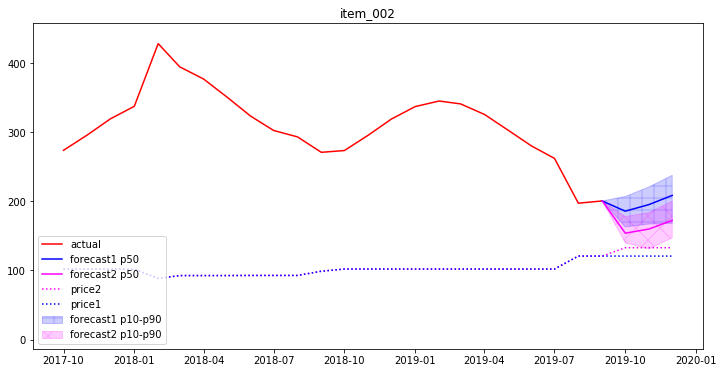

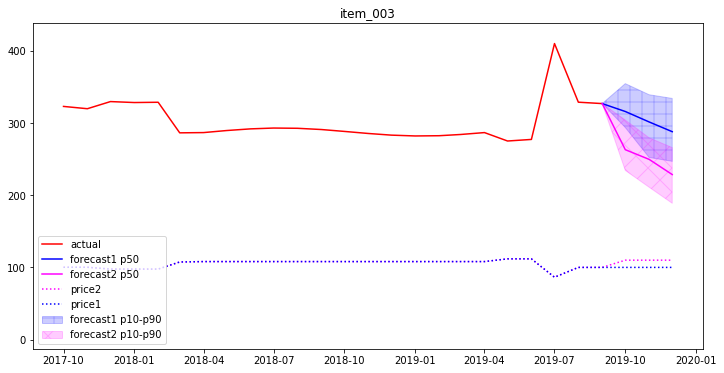

In [32]:
for item_id in [ "item_001", "item_002", "item_003" ]:
    plot_compare(item_id)


## Resource cleanup <a class="anchor" id="cleanup">

In [ ]:
# Delete forecasts
#util.wait_till_delete(lambda: forecast.delete_forecast(ForecastArn = forecast1_arn))
#util.wait_till_delete(lambda: forecast.delete_forecast(ForecastArn = forecast2_arn))

In [ ]:
# Delete predictor
#util.wait_till_delete(lambda: forecast.delete_predictor(PredictorArn = predictor_arn))

In [ ]:
# Delete dataset import jobs
#util.wait_till_delete(lambda: forecast.delete_dataset_import_job(DatasetImportJobArn = tts_dataset_import_job_arn))
#util.wait_till_delete(lambda: forecast.delete_dataset_import_job(DatasetImportJobArn = rts_dataset_import_job1_arn))
#util.wait_till_delete(lambda: forecast.delete_dataset_import_job(DatasetImportJobArn = rts_dataset_import_job2_arn))

In [ ]:
# Delete datasets
#util.wait_till_delete(lambda: forecast.delete_dataset(DatasetArn = tts_dataset_arn))
#util.wait_till_delete(lambda: forecast.delete_dataset(DatasetArn = rts_dataset_arn))

In [ ]:
# Delete dataset group
#util.wait_till_delete(lambda: forecast.delete_dataset_group(DatasetGroupArn = dataset_group_arn))

In [ ]:
# Delete IAM role
#util.delete_iam_role( role_name )